### 청와대 국민청원 데이터에서 각 분류별 Top1 추출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")
import datetime as dt
### 세종사전 실행
from konlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
twitter = Twitter()

In [2]:
df = pd.read_excel("test/test_저출산.xlsx")
df
# df.Date = pd.to_datetime(df.Date)

,Date,Title
0,2021-03-04,"불어난 몸, 가쁜 호흡 현실 속 임신부를 찍다"
1,2021-01-26,'늑장' 제설 '환장' 임신정보 자체감사 받는 서울시 황당 행정
2,2021-01-08,[단독] “출산 전 남편 속옷 챙기기” 성차별 홍보 근절법 나온다
3,2021-01-06,"만삭 임신부에 ""남편 챙겨라"" 서울시 사이트 뭇매"
4,2021-01-06,정의당 “만삭 아내에 남편 속옷 정리하라니 서울시 가관”
...,...,...
5041,2021-01-01,자가격리 윤일병사망사건 안예은 국방부 일상 청소년 군대군인 강남구 청년 본부장 손수...
5042,2021-01-01,청와대 국민청원
5043,2021-01-01,청와대 국민청원
5044,2021-01-01,코로나 걸려 죽기 전에 굶어 죽는다 자영업자 국민청원 건 육박


## 키워드 변경 함수

In [3]:
def rep_keyword(before, after):
    ind = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].index
    df.iloc[ind,2] = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].str.replace(before,after,case = False)

In [4]:
# rep_keyword("n번방","엔번방")
# rep_keyword("N번방","엔번방")

In [5]:
from string import punctuation
df2 = list(df.Title)

In [6]:
def strip_punc(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for sent in df2:
    clean_df = strip_punc(sent)
    clean_title.append(clean_df)

clean_title[0:3]

['불어난 몸 가쁜 호흡 현실 속 임신부를 찍다',
 '늑장 제설 환장 임신정보  자체감사 받는 서울시 황당 행정',
 '단독 “출산 전 남편 속옷 챙기기” 성차별 홍보 근절법 나온다']

In [7]:
from konlpy.tag import Kkma
kkma = Kkma()
import re
import time
import datetime
start = time.time()

dataset = []
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\s]','',clean_title[i])))
    
sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times)

0:01:56


In [8]:
from gensim import corpora, models
import gensim

In [9]:
high_score_reviews = dataset

In [10]:
high_score_reviews = [[y for y in x if not len(y)==1]
                     for x in high_score_reviews]
diction = corpora.Dictionary(high_score_reviews)
corpus = [diction.doc2bow(text) for text in high_score_reviews]


In [11]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = high_score_reviews, dictionary = diction,
                                        topn = 10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


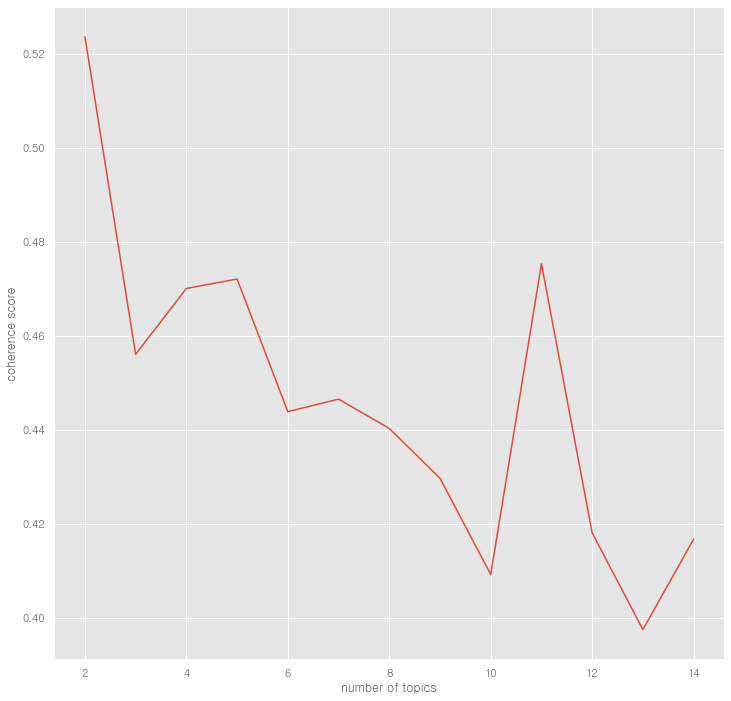

In [12]:
x = range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [13]:
import matplotlib.pyplot as plt
perplexity_values = []
for i in range(2, 20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

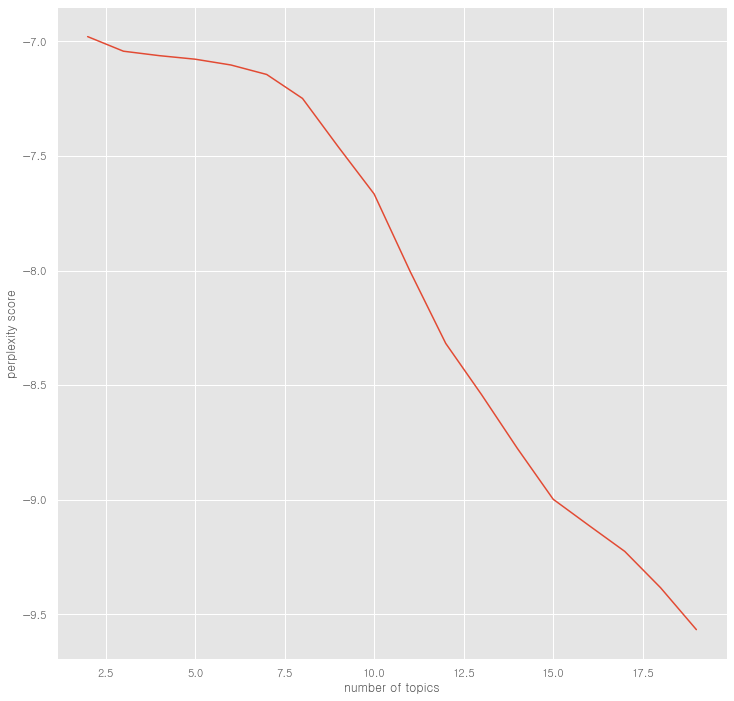

In [14]:
x = range(2,20)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [15]:
## 토픽 개수 7개 아니면 11개가 적당할거 같다.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= 7, alpha = 0.1, id2word= diction)

In [16]:
ldamodel.print_topics(num_words = 20)

[(0,
  '0.077*"국민" + 0.076*"청원" + 0.072*"국민청원" + 0.012*"청와대" + 0.010*"대통령" + 0.008*"낙연" + 0.008*"뉴스" + 0.006*"만명" + 0.005*"처벌" + 0.005*"묵살" + 0.005*"대한" + 0.004*"민국" + 0.004*"대한민국" + 0.004*"트위터" + 0.004*"도움" + 0.004*"등장" + 0.004*"게시판" + 0.004*"돌파" + 0.004*"다음" + 0.004*"사람"'),
 (1,
  '0.028*"청원" + 0.027*"국민" + 0.026*"국민청원" + 0.013*"사망" + 0.013*"사건" + 0.013*"청와대" + 0.013*"대한민국" + 0.013*"대한" + 0.013*"민국" + 0.013*"사회" + 0.012*"성폭력" + 0.012*"군대" + 0.012*"고함" + 0.011*"위원회" + 0.011*"청년" + 0.011*"군인" + 0.011*"캐스트" + 0.011*"부조리" + 0.011*"윤일병사망사건" + 0.011*"선진병영"'),
 (2,
  '0.057*"청원" + 0.056*"국민" + 0.054*"국민청원" + 0.028*"처벌" + 0.019*"정인" + 0.017*"학대" + 0.012*"관여" + 0.010*"수사" + 0.009*"연속" + 0.009*"대통령" + 0.008*"아이" + 0.008*"강간" + 0.008*"목격" + 0.008*"동의" + 0.008*"뉴스" + 0.007*"아동" + 0.007*"다음" + 0.007*"삭제" + 0.007*"원도" + 0.007*"청원도"'),
 (3,
  '0.110*"국민" + 0.110*"청원" + 0.106*"국민청원" + 0.017*"청와대" + 0.012*"동의" + 0.010*"만명" + 0.008*"뉴스" + 0.007*"처벌" + 0.007*"공유" + 0.006*"링크" + 0.006*"단체" + 0.005*"장애인"

In [17]:
import pyLDAvis

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float

In [18]:
from gensim.models import LdaModel # To use the LDA model

import pyLDAvis.gensim # To visualise LDA model effectively

import pandas as pd


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, diction)
vis

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.082981  0.080293       1        1  24.437440
3     -0.072447  0.059838       2        1  22.694024
0     -0.064029  0.044848       3        1  16.334913
1      0.239874  0.073702       4        1  10.201240
2     -0.046560 -0.015672       5        1  10.104229
5     -0.003142 -0.079474       6        1   8.586617
4      0.029285 -0.163535       7        1   7.641536, topic_info=     Term        Freq       Total Category  logprob  loglift
142    출처  239.000000  239.000000  Default  30.0000  30.0000
136   네이버  211.000000  211.000000  Default  29.0000  29.0000
137    뉴스  473.000000  473.000000  Default  28.0000  28.0000
695    처벌  428.000000  428.000000  Default  27.0000  27.0000
5621   정인  145.000000  145.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
361    나라   19.333950   53.526610   Topic7  -5.5023   1.5533
1174   하루   20.396513   72.947080   Topic7  -5.4488   1.2972
336    서울   18.156453   53.736470   Topic7  -5.5651   1.4865
1377   아이   18.986295  128.319421   Topic7  -5.5204   0.6608
196    동의   17.492671  424.852747   Topic7  -5.6024  -0.6184

[448 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2781      1  0.901110   가슴
1239      1  0.023920  간호사
1239      2  0.119598  간호사
1239      3  0.023920  간호사
1239      6  0.837189  간호사
...     ...       ...  ...
2212      2  0.779570   회장
2212      5  0.083525   회장
2212      6  0.111367   회장
626       5  0.958692   후보
787       2  0.925234   훼손

[886 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 2, 3, 6, 5])

In [19]:
kk = ldamodel.show_topic(5,topn = 80000)
type(ldamodel.show_topic)
kk2 = pd.DataFrame(kk)
#kk2.to_csv("test0911_1.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def make_topictable_per_doc(ldamodel,corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key = lambda x: (x[1]), reverse = True)
        
        
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num),round(prop_topic,4),topic_list]),
                                                ignore_index= True)
            else:
                break
                    
    return(topic_table)

                

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
topictable = make_topictable_per_doc(ldamodel,corpus)
topictable = topictable.reset_index()
topictable.columns = ["문서 번호", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]
topictable["문서 내용"] = df.Title
topictable = topictable.loc[:,["문서 번호", "문서 내용", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]]
topictable[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,문서 내용,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,"불어난 몸, 가쁜 호흡 현실 속 임신부를 찍다",2.0,0.8371,"[(0, 0.027158232), (1, 0.027172014), (2, 0.837..."
1,1,'늑장' 제설 '환장' 임신정보 자체감사 받는 서울시 황당 행정,3.0,0.9483,"[(3, 0.9483256)]"
2,2,[단독] “출산 전 남편 속옷 챙기기” 성차별 홍보 근절법 나온다,3.0,0.8413,"[(1, 0.11168063), (3, 0.84127957)]"
3,3,"만삭 임신부에 ""남편 챙겨라"" 서울시 사이트 뭇매",0.0,0.9100,"[(0, 0.91003823), (1, 0.01499613), (2, 0.01499..."
4,4,정의당 “만삭 아내에 남편 속옷 정리하라니 서울시 가관”,1.0,0.8094,"[(1, 0.80937815), (3, 0.14775814)]"
5,5,"""남편 반찬 챙겨라"" 임산부 분노케한 서울시, 원조는 복지부",0.0,0.9217,"[(0, 0.9217478), (1, 0.013042636), (2, 0.01304..."
6,6,국민청원 국민청원 크리스마스 이벤트 안하는 씹덕겜을 섭종시켜주세요,6.0,0.9218,"[(0, 0.0130289355), (1, 0.01302843), (2, 0.013..."
7,7,국민청원 신재생에너지로 정맠을 추천합니다 ㄴ 얘네 눈빛으로 물도 끓일 ...,3.0,0.9378,"[(0, 0.010369327), (1, 0.010368765), (2, 0.010..."
8,8,판사 검사 자녀들의 입시비리 전수조사 국민청원 조민양은 엄마가 교도소에 있으...,2.0,0.6628,"[(2, 0.6628152), (6, 0.32083413)]"
9,9,금융감독원 사이코패스 자들의 심각한 도덕적해이 반사회적행...,3.0,0.9592,"[(3, 0.9591703)]"


In [22]:
# topictable.to_csv("test0911_2.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
